<a href="https://colab.research.google.com/github/rishit020/rishit-ml-portfolio/blob/main/supervised-learning/CustomerChurn_Prediction/CustomerChurn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction

This notebook builds a supervised machine learning pipeline to predict customer churn.
The workflow includes data cleaning, feature engineering, class imbalance handling,
model training, hyperparameter tuning, and evaluation.

Dataset: Telco Customer Churn
Model: Logistic Regression with SMOTE
Metric Focus: F1-score


In [68]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [69]:
df = pd.read_csv("churn.csv")

In [70]:
df = df.drop(columns=["customerID"])

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

service_cols = [
    "MultipleLines", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]

for col in service_cols:
    df[col] = df[col].replace(
        {"No phone service": "No", "No internet service": "No"}
    )

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


/tmp/ipython-input-1766882737.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [72]:
df["TotalServices"] = df[service_cols].apply(lambda x: (x == "Yes").sum(), axis=1)

df["TenureGroup"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, 60, 100],
    labels=["0-1yr", "1-2yr", "2-4yr", "4-5yr", "5+yr"]
)

In [73]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [74]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [75]:
pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(
        solver="liblinear",
        class_weight=None,
        random_state=42
    ))
])

In [76]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best Params: {'model__C': 0.1, 'model__penalty': 'l2'}
Best CV F1: 0.631479828136702


In [77]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("Train F1:", f1_score(y_train, y_train_pred))
print("Test F1:", f1_score(y_test, y_test_pred))


Train F1: 0.6337317397078354
Test F1: 0.620253164556962


In [78]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[755, 280],
       [ 80, 294]])

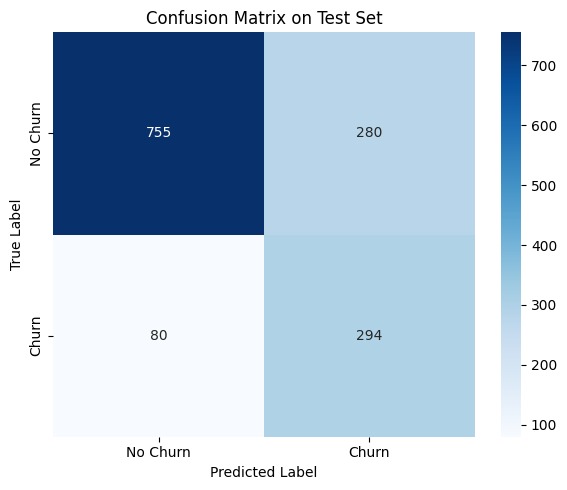

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

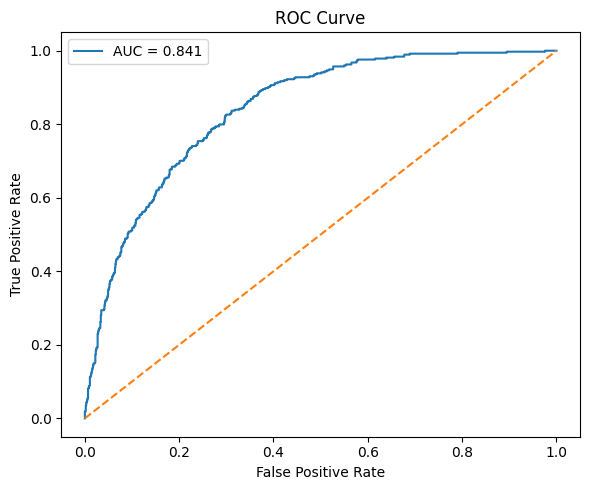

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

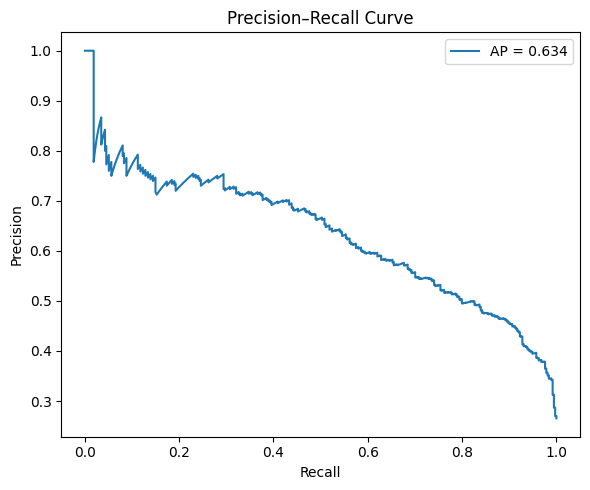

In [82]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
avg_precision = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

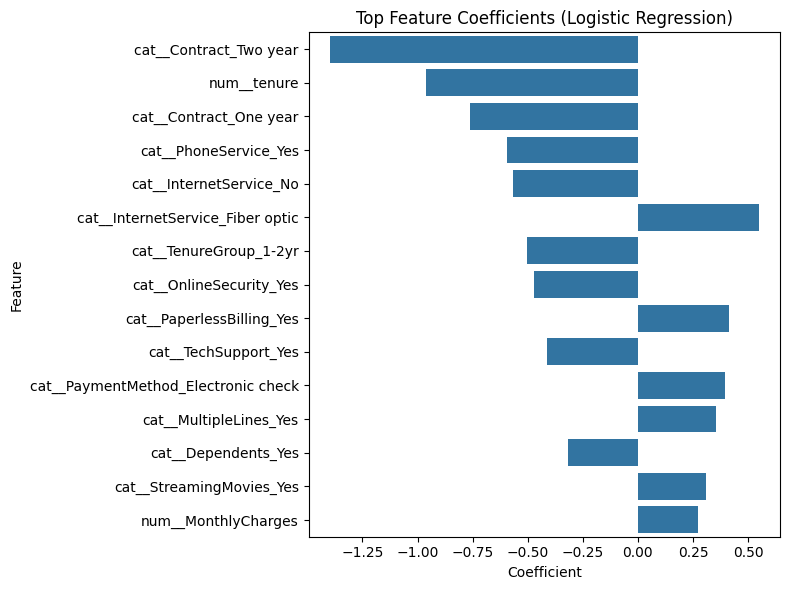

In [83]:
feature_names = (
    best_model.named_steps["preprocessor"]
    .get_feature_names_out()
)

coefficients = best_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

top_features = coef_df.head(15)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_features,
    x="Coefficient",
    y="Feature"
)
plt.title("Top Feature Coefficients (Logistic Regression)")
plt.tight_layout()
plt.show()

## Conclusion

A Logistic Regression model with SMOTE and tuned regularization achieved the best
F1-score while maintaining reasonable generalization. Future improvements may include
tree-based ensembles and threshold optimization.